In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import georasters as gr
from os import listdir
from os.path import isfile, join, isdir
from math import hypot

%matplotlib inline

### Methods for querying

In [2]:
def get_geoObject(file_path):
    geoObject = {}
    NDV, xsize, ysize, GeoT, Projection, DataType = gr.get_geo_info(file_path)

    key_list = ['NDV', 'xsize', 'ysize', 'GeoT', 'Projection', 'DataType']
    value_list = [NDV, xsize, ysize, GeoT, Projection, DataType]
    for i in range(len(key_list)):
        geoObject[key_list[i]] = value_list[i]
    
    return geoObject

In [3]:
# Returns the cell that is closest to the coordinate point x (Latitute), y (Longitude).
def find_value_for_point(x, y, df, geoObject):
    GeoT = geoObject['GeoT']
    row, col = gr.map_pixel(y,x,GeoT[1],GeoT[-1], GeoT[0],GeoT[3])
    # For some reason the result is off by one so add 1 to both row and column.
    return df[(df['row'] == row+1) & (df['col'] == col+1)]

In [4]:
# Returns a list of the n most produced crops for the given point.
# Returns it as a list of n triples, for each triple:
# - First item is a tuple containing the name of the crop.
# - Seond item is a float value representing the production of the above crop at given point.

def top_n_crops_produced_at_point(x, y, n, df, geoObject):
    # Get the cell corresponding to the point.
    cell = find_value_for_point(x, y, df, geoObject)
    print(cell)
    if (cell.empty):
        return None
    # Ignore values for column, row, x, y for the query.
    cell = cell[cell.columns.difference(['col', 'row', 'x', 'y'])]
    best_crops = cell.sort_values(by=cell.index[0], ascending=False, axis=1).iloc[:,0:n]
    top_n = []   
    for column in best_crops:
        crop = best_crops[column]
        crop_name = crop.name
        value = round(crop.values[0], 3)
        if (value != 0):
            top_n.append((crop_name, value))
    return top_n

In [5]:
# Returns a list of the n most productive cells for the given crop.
# Returns it as a list of n triples, for each triple:
# - First item is a tuple containing the Latitude/Longitude of the point.
# - Seond item is a float value representing the production of the input crop at above point.

def top_n_production_points_for_crop(crop_name, n, df):
    best_cells = df.loc[df[crop_name].nlargest(n).index]
    top_n = []
    for index, cell in best_cells.iterrows():
        # Round coordinates to match Lat/Long format
        x = round(cell['x'], 6)
        y = round(cell['y'], 6)
        value = round(cell[crop_name], 4)
        bundle = ((y, x), value)
        top_n.append(bundle)
    return top_n

## Using EarthStat Data

Join all data for Crop Production Into Single Table

Aggregate all files into one.

In [145]:
crop_files_path = '../data/crop-production/HarvestedAreaYield175Crops_Geotiff/'
crop_folders = [f for f in listdir(crop_files_path) if isdir(crop_files_path+'/'+f)]

# Get first crop to be base dataframe.
crop_folder = crop_folders[0]
production_file = [f for f in listdir(crop_files_path+'/'+crop_folder) if 'Production' in f][0]
crop_name = production_file.split('_')[0]
raster = crop_files_path + '/' + crop_folder + '/' + production_file
data = gr.from_file(raster)
df_estat = data.to_pandas()
df_estat.rename(columns={'value':crop_name}, inplace=True)

for crop_folder in crop_folders[1:]:
    production_file = [f for f in listdir(crop_files_path+'/'+crop_folder) if 'Production' in f][0]
    crop_name = production_file.split('_')[0]
    raster = crop_files_path + '/' + crop_folder + '/' + production_file
    data = gr.from_file(raster)
    temp_df = data.to_pandas()

Save aggregated data into csv

In [ ]:
df_estat.to_csv('./estat_production_aggregated_data.csv')

In [12]:
# To read the data:
df_estat = pd.read_csv('../data/crop-production/my_aggregates/estat_production_aggregated_data.csv', index_col=0)

/Users/Christian/anaconda/envs/try_georasters3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [13]:
df_estat.head()

row   col  linseed          x          y  cocoa  almond  onion  aniseetc  \
0   76  1766      0.0 -32.833333  83.666667    0.0     0.0    0.0       0.0   
1   76  1767      0.0 -32.750000  83.666667    0.0     0.0    0.0       0.0   
2   76  1768      0.0 -32.666667  83.666667    0.0     0.0    0.0       0.0   
3   76  1769      0.0 -32.583333  83.666667    0.0     0.0    0.0       0.0   
4   77  1720      0.0 -36.666667  83.583333    0.0     0.0    0.0       0.0   

   millet   ...    oats  sunflower  blueberry  tangetc  rice  spicenes  apple  \
0     0.0   ...     0.0        0.0        0.0      0.0   0.0       0.0    0.0   
1     0.0   ...     0.0        0.0        0.0      0.0   0.0       0.0    0.0   
2     0.0   ...     0.0        0.0        0.0      0.0   0.0       0.0    0.0   
3     0.0   ...     0.0        0.0        0.0      0.0   0.0       0.0    0.0   
4     0.0   ...     0.0        0.0        0.0      0.0   0.0       0.0    0.0   

   avocado  carrot  cherry  
0      0.0     0.0     0.0  
1      0.0     0.0     0.0  
2      0.0     0.0     0.0  
3      0.0     0.0     0.0  
4      0.0     0.0     0.0  

[5 rows x 179 columns]

Get place that grows most bananas bananas and the top crop produced at the given point

In [30]:
# Get one geoObject. They'll be the same for all estat files
estat_geoObject = get_geoObject('../data/crop-production/HarvestedAreaYield175Crops_Geotiff/abaca_HarvAreaYield2000_Geotiff/abaca_Production.tif')

In [31]:
point = (17.147881, 79.838198)

print(top_n_production_points_for_crop('banana', 1, df_estat))
print('\n')
print(top_n_crops_produced_at_point(point[0], point[1], 3, df_estat, estat_geoObject))

[((-3.25, -79.916667), 76559.74)]


[('rice', 5527.54), ('fornes', 3307.125), ('mango', 961.265)]


## USING SPAM DATA

Create Table with all of SPAM data for Rainfed crops

In [440]:
crop_files_path = './data/crop-production/geotiff_global_prod/'
geoObject = {}

#*_TA	all technologies together, ie complete crop
#*_TI	irrigated portion of crop
#*_TH	rainfed high inputs portion of crop
#*_TL	rainfed low inputs portion of crop
#*_TS	rainfed subsistence portion of crop
#*_TR	rainfed portion of crop (= TA - TI, or TH + TL + TS)
technology = 'TR'

production_files = [f for f in crop_folders if '.tif' in f and '.xml' not in f and technology in f]

# Get first crop to be base dataframe.
production_file = production_files[0]
crop_name = production_file.split('_')[4]
raster = crop_files_path + '/' + production_file
data = gr.from_file(raster)
NDV, xsize, ysize, GeoT, Projection, DataType = gr.get_geo_info(raster)
key_list = ['NDV', 'xsize', 'ysize', 'GeoT', 'Projection', 'DataType']
value_list = [NDV, xsize, ysize, GeoT, Projection, DataType]
for i in range(len(key_list)):
    geoObject[key_list[i]] = value_list[i] 

df_spam = data.to_pandas()
df_spam.rename(columns={'value':crop_name}, inplace=True)

for production_f in production_files:
    crop_name = production_f.split('_')[4]
    raster = crop_files_path + '/' + production_f
    data = gr.from_file(raster)
    NDV, xsize, ysize, GeoT, Projection, DataType = gr.get_geo_info(raster)
    key_list = ['NDV', 'xsize', 'ysize', 'GeoT', 'Projection', 'DataType']
    value_list = [NDV, xsize, ysize, GeoT, Projection, DataType]
    for i in range(len(key_list)):
        geoObject[key_list[i]] = value_list[i] 

    temp_df = data.to_pandas()    
    df_spam[crop_name] = temp_df['value']

In [370]:
df_spam.to_csv('./spam_production_TR_aggregated_data.csv')

In [36]:
df_spam = pd.read_csv('../data/crop-production/my_aggregates/spam_production_TR_aggregated_data.csv', index_col=0)

In [45]:
spam_geoObject = get_geoObject('../data/crop-production/geotiff_global_prod/SPAM2005V3r2_global_P_TA_ACOF_A.tif')

In [53]:
df_spam.head()

row   col          x          y  OILP  TROF  SUNF  OPUL  TEMF  SOYB  ...   \
0  226  2491  27.583333  71.166667   0.0   0.0   0.0   0.0   1.0   0.0  ...    
1  226  2492  27.666667  71.166667   0.0   0.0   0.0   0.0   1.4   0.0  ...    
2  227  2446  23.833333  71.083333   0.0   0.0   0.0   0.0   1.4   0.0  ...    
3  227  2447  23.916667  71.083333   0.0   0.0   0.0   0.0   1.0   0.0  ...    
4  227  2448  24.000000  71.083333   0.0   0.0   0.0   0.0   2.3   0.0  ...    

   OFIB  RICE  SMIL  ORTS  RCOF  PLNT  SUGB  GROU  COTT  PIGE  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 46 columns]

In [55]:
print(top_n_production_points_for_crop('BANA', 1, df_spam))
print('\n')
print(top_n_crops_produced_at_point(point[0], point[1], 2, df_spam, spam_geoObject))

[((10.416667, 78.25), 299639.0)]


        row   col          x          y  OILP  TROF  SUNF  OPUL  TEMF  SOYB  \
479713  955  3100  78.333333  10.416667   0.0   2.6   0.0  21.2   0.0   0.0   

        ...   OFIB  RICE  SMIL  ORTS  RCOF  PLNT  SUGB  GROU  COTT  PIGE  
479713  ...    0.0   0.0  11.2   0.0   0.0   0.0   0.0   0.7   0.4  10.4  

[1 rows x 46 columns]
[('BANA', 271940.3), ('VEGE', 405.4)]


In [6]:
# Get first crop to be base dataframe.
raster = './wc2.0_bio_5m_01.tif'
data = gr.from_file(raster)
df_estat = data.to_pandas()

In [7]:
data.plot()

In [12]:
# Get first crop to be base dataframe.
raster = './spam2005v3r2_production_banana_rainfed.tiff'
data2 = gr.from_file(raster)
df_estat2 = data2.to_pandas()

In [11]:
top_n_production_points_for_crop('value', 1, df_estat)

[((13.0, 41.166667), 33.6616)]

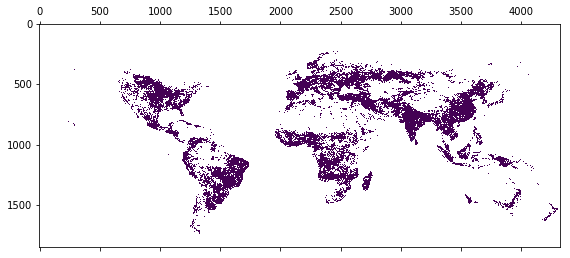

In [9]:
data2.plot()

In [1]:
df_merged = pd.read_csv('/Volumes/Christian_2015/project-eden/my_aggregates/production_clim_merged_georasters.csv', index_col=0)

NameError: name 'pd' is not defined